<a href="https://colab.research.google.com/github/michael-borck/weatherwise-template/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [4]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai


In [5]:
# Optional: Set up hands-on-ai package (only needed if using AI chat features)
# You can skip this cell if you're not using the AI chat functionality
import os

# Uncomment these lines only if you want to use hands-on-ai chat features
# os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
# os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
# os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

print("Setup complete! The WeatherWise app uses wttr.in API which doesn't require an API key.")

Setup complete! The WeatherWise app uses wttr.in API which doesn't require an API key.


## 📦 Setup and Configuration
Import required packages and setup environment.

In [6]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

# Optional imports - only needed if using specific features
try:
    from fetch_my_weather import get_weather
    print("fetch_my_weather package available (optional)")
except ImportError:
    print("fetch_my_weather not installed - using direct API approach")

try:
    from hands_on_ai.chat import get_response
    print("hands_on_ai package available (optional)")
except ImportError:
    print("hands_on_ai not installed - continuing without AI chat features")

print("Core imports successful! Ready to build WeatherWise.")

fetch_my_weather package available (optional)
hands_on_ai package available (optional)
Core imports successful! Ready to build WeatherWise.


## 🌤️ Weather Data Functions

In [7]:
import json
from datetime import datetime, timedelta

def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location using wttr.in API.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
        # Use wttr.in API with JSON format
        url = f"https://wttr.in/{location}?format=j1"
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            # Extract current weather
            current = data.get('current_condition', [{}])[0]
            
            # Extract forecast data (limit to requested days)
            forecast = data.get('weather', [])[:forecast_days]
            
            # Process and structure the data
            processed_data = {
                'location': location,
                'current': {
                    'temperature': int(current.get('temp_C', 0)),
                    'feels_like': int(current.get('FeelsLikeC', 0)),
                    'humidity': int(current.get('humidity', 0)),
                    'description': current.get('weatherDesc', [{}])[0].get('value', 'Unknown'),
                    'wind_speed': int(current.get('windspeedKmph', 0)),
                    'wind_direction': current.get('winddir16Point', 'N'),
                    'pressure': int(current.get('pressure', 0)),
                    'visibility': int(current.get('visibility', 0))
                },
                'forecast': []
            }
            
            # Process forecast data
            for day_data in forecast:
                date = day_data.get('date', '')
                
                # Get min/max temperatures from hourly data
                hourly = day_data.get('hourly', [])
                temps = [int(h.get('tempC', 0)) for h in hourly]
                precip = [float(h.get('precipMM', 0)) for h in hourly]
                
                day_info = {
                    'date': date,
                    'max_temp': max(temps) if temps else 0,
                    'min_temp': min(temps) if temps else 0,
                    'avg_temp': sum(temps) // len(temps) if temps else 0,
                    'precipitation': max(precip) if precip else 0,
                    'description': day_data.get('hourly', [{}])[0].get('weatherDesc', [{}])[0].get('value', 'Unknown'),
                    'hourly_temps': temps,
                    'hourly_precip': precip
                }
                processed_data['forecast'].append(day_info)
            
            return processed_data
            
        else:
            return {
                'error': f'Failed to fetch weather data for {location}. Status code: {response.status_code}',
                'location': location,
                'current': {},
                'forecast': []
            }
            
    except requests.exceptions.RequestException as e:
        return {
            'error': f'Network error: {str(e)}',
            'location': location,
            'current': {},
            'forecast': []
        }
    except Exception as e:
        return {
            'error': f'Error processing weather data: {str(e)}',
            'location': location,
            'current': {},
            'forecast': []
        }

## 📊 Visualisation Functions

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    if 'error' in weather_data:
        print(f"Cannot create visualization: {weather_data['error']}")
        return None
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for plotting
    dates = []
    max_temps = []
    min_temps = []
    avg_temps = []
    
    for day in weather_data['forecast']:
        try:
            date_obj = datetime.strptime(day['date'], '%Y-%m-%d')
            dates.append(date_obj)
            max_temps.append(day['max_temp'])
            min_temps.append(day['min_temp'])
            avg_temps.append(day['avg_temp'])
        except ValueError:
            continue
    
    if not dates:
        print("No valid date data found for visualization")
        return None
    
    # Create the plot
    ax.plot(dates, max_temps, 'r-o', label='Max Temperature', linewidth=2, markersize=6)
    ax.plot(dates, min_temps, 'b-o', label='Min Temperature', linewidth=2, markersize=6)
    ax.plot(dates, avg_temps, 'g-o', label='Average Temperature', linewidth=2, markersize=6)
    
    # Fill between max and min temperatures
    ax.fill_between(dates, min_temps, max_temps, alpha=0.3, color='orange')
    
    # Format the plot
    ax.set_title(f'Temperature Forecast for {weather_data["location"]}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Format dates on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    
    # Add current temperature indicator
    current_temp = weather_data['current'].get('temperature', 0)
    if current_temp > 0:
        ax.axhline(y=current_temp, color='red', linestyle='--', alpha=0.7, 
                  label=f'Current: {current_temp}°C')
        ax.legend(fontsize=10)
    
    plt.tight_layout()
    
    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [9]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    if 'error' in weather_data:
        print(f"Cannot create visualization: {weather_data['error']}")
        return None
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Prepare data for plotting
    dates = []
    precipitation = []
    
    for day in weather_data['forecast']:
        try:
            date_obj = datetime.strptime(day['date'], '%Y-%m-%d')
            dates.append(date_obj)
            precipitation.append(day['precipitation'])
        except ValueError:
            continue
    
    if not dates:
        print("No valid date data found for visualization")
        return None
    
    # Top plot: Daily precipitation bar chart
    bars = ax1.bar(dates, precipitation, color='skyblue', alpha=0.7, edgecolor='navy')
    ax1.set_title(f'Precipitation Forecast for {weather_data["location"]}', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Precipitation (mm)', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, precip in zip(bars, precipitation):
        if precip > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{precip:.1f}mm', ha='center', va='bottom', fontsize=10)
    
    # Format dates on x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    
    # Bottom plot: Hourly precipitation for first day (if available)
    if weather_data['forecast'] and weather_data['forecast'][0].get('hourly_precip'):
        hourly_precip = weather_data['forecast'][0]['hourly_precip']
        hours = list(range(0, len(hourly_precip) * 3, 3))  # Assuming 3-hour intervals
        
        ax2.plot(hours, hourly_precip, 'o-', color='blue', linewidth=2, markersize=6)
        ax2.fill_between(hours, hourly_precip, alpha=0.3, color='lightblue')
        ax2.set_title(f'Hourly Precipitation - {weather_data["forecast"][0]["date"]}', fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_ylabel('Precipitation (mm)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, 21)
        
        # Add precipitation intensity labels
        max_precip = max(hourly_precip) if hourly_precip else 0
        if max_precip > 10:
            intensity = "Heavy Rain"
            color = "red"
        elif max_precip > 2.5:
            intensity = "Moderate Rain"
            color = "orange"
        elif max_precip > 0.1:
            intensity = "Light Rain"
            color = "green"
        else:
            intensity = "No Rain"
            color = "gray"
        
        ax2.text(0.02, 0.98, f'Intensity: {intensity}', transform=ax2.transAxes,
                fontsize=12, fontweight='bold', color=color,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    else:
        ax2.text(0.5, 0.5, 'Hourly precipitation data not available', 
                transform=ax2.transAxes, ha='center', va='center', fontsize=12)
        ax2.set_title('Hourly Precipitation - Data Not Available', fontsize=14)
    
    plt.tight_layout()
    
    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

## 🤖 Natural Language Processing

In [10]:
import re
from datetime import datetime, timedelta

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    question_lower = question.lower()
    
    # Initialize result dictionary
    parsed = {
        'location': None,
        'time_period': 'today',
        'weather_attribute': 'general',
        'question_type': 'general',
        'original_question': question
    }
    
    # Extract location using common patterns
    location_patterns = [
        r'in ([A-Za-z\s]+?)(?:\s|$|\?|,)',
        r'for ([A-Za-z\s]+?)(?:\s|$|\?|,)',
        r'at ([A-Za-z\s]+?)(?:\s|$|\?|,)',
        r'([A-Za-z]+(?:\s+[A-Za-z]+)*)',  # Fallback: any sequence of words
    ]
    
    # Remove common weather words to better isolate location
    weather_words = ['weather', 'temperature', 'rain', 'snow', 'wind', 'cloudy', 'sunny', 
                    'today', 'tomorrow', 'will', 'be', 'like', 'hot', 'cold', 'warm',
                    'forecast', 'precipitation', 'humidity', 'pressure']
    
    question_cleaned = question_lower
    for word in weather_words:
        question_cleaned = re.sub(r'\b' + word + r'\b', '', question_cleaned)
    
    # Look for location
    for pattern in location_patterns:
        match = re.search(pattern, question_cleaned)
        if match:
            location = match.group(1).strip()
            if location and len(location) > 1:
                parsed['location'] = location.title()
                break
    
    # Extract time period
    if any(word in question_lower for word in ['tomorrow', 'next day']):
        parsed['time_period'] = 'tomorrow'
    elif any(word in question_lower for word in ['today', 'now', 'current']):
        parsed['time_period'] = 'today'
    elif any(word in question_lower for word in ['week', 'days', 'forecast']):
        parsed['time_period'] = 'week'
    elif re.search(r'\d+\s*day', question_lower):
        match = re.search(r'(\d+)\s*day', question_lower)
        if match:
            parsed['time_period'] = f'{match.group(1)}_days'
    
    # Extract weather attribute
    if any(word in question_lower for word in ['temperature', 'temp', 'hot', 'cold', 'warm', 'cool']):
        parsed['weather_attribute'] = 'temperature'
    elif any(word in question_lower for word in ['rain', 'precipitation', 'shower', 'drizzle']):
        parsed['weather_attribute'] = 'precipitation'
    elif any(word in question_lower for word in ['wind', 'windy', 'breeze']):
        parsed['weather_attribute'] = 'wind'
    elif any(word in question_lower for word in ['humidity', 'humid']):
        parsed['weather_attribute'] = 'humidity'
    elif any(word in question_lower for word in ['pressure', 'atmospheric']):
        parsed['weather_attribute'] = 'pressure'
    elif any(word in question_lower for word in ['cloudy', 'clouds', 'overcast', 'sunny', 'clear']):
        parsed['weather_attribute'] = 'conditions'
    
    # Determine question type
    if any(word in question_lower for word in ['will', 'going to', 'forecast']):
        parsed['question_type'] = 'forecast'
    elif any(word in question_lower for word in ['is', 'current', 'now', 'today']):
        parsed['question_type'] = 'current'
    elif any(word in question_lower for word in ['should', 'good for', 'recommend']):
        parsed['question_type'] = 'advisory'
    
    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    if 'error' in weather_data:
        return f"Sorry, I couldn't get weather information for {parsed_question.get('location', 'that location')}. {weather_data['error']}"
    
    location = weather_data['location']
    current = weather_data['current']
    forecast = weather_data['forecast']
    
    # Get the requested information based on time period and attribute
    time_period = parsed_question.get('time_period', 'today')
    attribute = parsed_question.get('weather_attribute', 'general')
    question_type = parsed_question.get('question_type', 'general')
    
    response_parts = []
    
    # Handle different time periods
    if time_period == 'today' or question_type == 'current':
        if attribute == 'temperature':
            temp = current.get('temperature', 0)
            feels_like = current.get('feels_like', 0)
            response_parts.append(f"Currently in {location}, it's {temp}°C (feels like {feels_like}°C).")
        
        elif attribute == 'precipitation':
            # Check today's forecast for precipitation
            today_precip = forecast[0].get('precipitation', 0) if forecast else 0
            if today_precip > 0:
                response_parts.append(f"There's precipitation expected today in {location} with up to {today_precip}mm of rain.")
            else:
                response_parts.append(f"No precipitation is expected today in {location}.")
        
        elif attribute == 'wind':
            wind_speed = current.get('wind_speed', 0)
            wind_dir = current.get('wind_direction', 'N')
            response_parts.append(f"Wind in {location} is currently {wind_speed} km/h from the {wind_dir}.")
        
        elif attribute == 'humidity':
            humidity = current.get('humidity', 0)
            response_parts.append(f"The humidity in {location} is currently {humidity}%.")
        
        else:  # general conditions
            temp = current.get('temperature', 0)
            desc = current.get('description', 'Unknown')
            response_parts.append(f"In {location}, it's currently {temp}°C with {desc.lower()}.")
    
    elif time_period == 'tomorrow':
        if len(forecast) > 1:
            tomorrow = forecast[1]
            if attribute == 'temperature':
                max_temp = tomorrow.get('max_temp', 0)
                min_temp = tomorrow.get('min_temp', 0)
                response_parts.append(f"Tomorrow in {location}, temperatures will range from {min_temp}°C to {max_temp}°C.")
            
            elif attribute == 'precipitation':
                precip = tomorrow.get('precipitation', 0)
                if precip > 0:
                    response_parts.append(f"Tomorrow in {location}, expect up to {precip}mm of precipitation.")
                else:
                    response_parts.append(f"No precipitation expected tomorrow in {location}.")
            
            else:  # general
                max_temp = tomorrow.get('max_temp', 0)
                min_temp = tomorrow.get('min_temp', 0)
                desc = tomorrow.get('description', 'Unknown')
                response_parts.append(f"Tomorrow in {location}: {desc.lower()}, {min_temp}°C to {max_temp}°C.")
        else:
            response_parts.append(f"Sorry, I don't have tomorrow's forecast for {location}.")
    
    elif time_period == 'week' or 'days' in time_period:
        if forecast:
            if attribute == 'temperature':
                temps = [day.get('max_temp', 0) for day in forecast]
                avg_max = sum(temps) / len(temps) if temps else 0
                response_parts.append(f"Over the next {len(forecast)} days in {location}, average high temperature will be around {avg_max:.1f}°C.")
            
            elif attribute == 'precipitation':
                total_precip = sum(day.get('precipitation', 0) for day in forecast)
                rainy_days = sum(1 for day in forecast if day.get('precipitation', 0) > 0.1)
                response_parts.append(f"In the {len(forecast)}-day forecast for {location}, expect {total_precip:.1f}mm total precipitation over {rainy_days} rainy days.")
            
            else:  # general forecast
                response_parts.append(f"Here's the {len(forecast)}-day forecast for {location}:")
                for i, day in enumerate(forecast[:3]):  # Show first 3 days
                    date = day.get('date', f'Day {i+1}')
                    max_temp = day.get('max_temp', 0)
                    min_temp = day.get('min_temp', 0)
                    desc = day.get('description', 'Unknown')
                    response_parts.append(f"• {date}: {desc.lower()}, {min_temp}°C to {max_temp}°C")
        else:
            response_parts.append(f"Sorry, I don't have extended forecast data for {location}.")
    
    # Add advisory information if requested
    if question_type == 'advisory':
        current_temp = current.get('temperature', 0)
        if current_temp > 25:
            response_parts.append("It's quite warm - consider light clothing and stay hydrated!")
        elif current_temp < 5:
            response_parts.append("It's cold - dress warmly and be careful of icy conditions!")
        
        # Check for precipitation
        today_precip = forecast[0].get('precipitation', 0) if forecast else 0
        if today_precip > 5:
            response_parts.append("Significant rain expected - bring an umbrella!")
    
    return ' '.join(response_parts) if response_parts else f"I have weather data for {location}, but couldn't determine what specific information you're looking for."

## 🧭 User Interface

In [11]:
def display_weather_summary(weather_data):
    """Display a formatted weather summary."""
    if 'error' in weather_data:
        print(f"Error: {weather_data['error']}")
        return
    
    location = weather_data['location']
    current = weather_data['current']
    
    print(f"\nCurrent Weather in {location}")
    print("=" * 50)
    print(f"Temperature: {current.get('temperature', 0)}°C (feels like {current.get('feels_like', 0)}°C)")
    print(f"Conditions: {current.get('description', 'Unknown')}")
    print(f"Humidity: {current.get('humidity', 0)}%")
    print(f"Wind: {current.get('wind_speed', 0)} km/h {current.get('wind_direction', 'N')}")
    print(f"Pressure: {current.get('pressure', 0)} hPa")
    print(f"Visibility: {current.get('visibility', 0)} km")

def main_menu():
    """Main menu interface for the Weather Advisor application."""
    print("\nWelcome to WeatherWise - Your Intelligent Weather Advisor!")
    print("=" * 60)
    
    while True:
        print("\nMain Menu:")
        print("1. Get weather forecast with visualizations")
        print("2. Ask a weather question in natural language")
        print("3. Compare weather for multiple locations")
        print("4. Exit")
        
        try:
            choice = pyip.inputMenu(['1', '2', '3', '4'], 
                                  prompt="Please select an option (1-4): ",
                                  numbered=False)
            
            if choice == '1':
                weather_forecast_menu()
            elif choice == '2':
                natural_language_menu()
            elif choice == '3':
                compare_locations_menu()
            elif choice == '4':
                print("\nThank you for using WeatherWise! Stay safe and dry!")
                break
                
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"An error occurred: {e}")

def weather_forecast_menu():
    """Weather forecast menu with visualization options."""
    print("\nWeather Forecast & Visualization")
    print("=" * 40)
    
    # Get location
    location = pyip.inputStr("Enter city name: ", strip=True)
    
    # Get forecast duration
    days = pyip.inputInt("Number of forecast days (1-5): ", 
                        min=1, max=5, default=5)
    
    print(f"\nFetching weather data for {location}...")
    weather_data = get_weather_data(location, days)
    
    if 'error' in weather_data:
        print(f"Error: {weather_data['error']}")
        return
    
    # Display summary
    display_weather_summary(weather_data)
    
    # Show forecast
    print(f"\n{days}-Day Forecast:")
    print("-" * 40)
    for day in weather_data['forecast']:
        print(f"{day['date']}: {day['min_temp']}°C to {day['max_temp']}°C, {day['description']}")
        if day['precipitation'] > 0:
            print(f"           Precipitation: {day['precipitation']}mm")
    
    # Visualization options
    print("\nVisualization Options:")
    vis_choice = pyip.inputMenu(['Temperature trends', 'Precipitation forecast', 'Both', 'Skip'],
                               prompt="What would you like to visualize? ",
                               numbered=True)
    
    if vis_choice in ['Temperature trends', 'Both']:
        print("\nGenerating temperature visualization...")
        create_temperature_visualisation(weather_data)
    
    if vis_choice in ['Precipitation forecast', 'Both']:
        print("\nGenerating precipitation visualization...")
        create_precipitation_visualisation(weather_data)
    
    input("\nPress Enter to return to main menu...")

def natural_language_menu():
    """Natural language question interface."""
    print("\nNatural Language Weather Assistant")
    print("=" * 45)
    print("Ask me anything about the weather! Examples:")
    print("• 'What's the weather like in Paris?'")
    print("• 'Will it rain tomorrow in London?'")
    print("• 'How hot will it be in Tokyo this week?'")
    print("• Type 'back' to return to main menu")
    
    while True:
        print("\n" + "-" * 45)
        question = pyip.inputStr("Your weather question: ", strip=True)
        
        if question.lower() in ['back', 'return', 'menu']:
            break
        
        print(f"\nAnalyzing your question...")
        parsed = parse_weather_question(question)
        
        # If no location detected, ask for it
        if not parsed['location']:
            location = pyip.inputStr("I couldn't detect a location. Please specify: ", strip=True)
            parsed['location'] = location
        
        print(f"Getting weather data for {parsed['location']}...")
        weather_data = get_weather_data(parsed['location'])
        
        response = generate_weather_response(parsed, weather_data)
        print(f"\nWeather Assistant: {response}")
        
        # Offer to show visualizations
        if 'error' not in weather_data:
            show_viz = pyip.inputYesNo("\nWould you like to see weather visualizations? ")
            if show_viz == 'yes':
                viz_type = pyip.inputMenu(['Temperature', 'Precipitation', 'Both'],
                                        prompt="What type of visualization? ",
                                        numbered=True)
                
                if viz_type in ['Temperature', 'Both']:
                    create_temperature_visualisation(weather_data)
                if viz_type in ['Precipitation', 'Both']:
                    create_precipitation_visualisation(weather_data)

def compare_locations_menu():
    """Compare weather between multiple locations."""
    print("\nWeather Comparison Tool")
    print("=" * 35)
    
    locations = []
    while len(locations) < 2:
        location = pyip.inputStr(f"Enter location {len(locations) + 1}: ", strip=True)
        locations.append(location)
    
    # Ask if they want to add more locations
    while len(locations) < 5:
        add_more = pyip.inputYesNo(f"Add another location? (Current: {len(locations)}) ")
        if add_more == 'no':
            break
        location = pyip.inputStr(f"Enter location {len(locations) + 1}: ", strip=True)
        locations.append(location)
    
    print(f"\nFetching weather data for {len(locations)} locations...")
    
    # Get weather data for all locations
    weather_comparison = []
    for location in locations:
        data = get_weather_data(location, 3)  # 3-day forecast
        weather_comparison.append(data)
    
    # Display comparison
    print("\nWeather Comparison")
    print("=" * 60)
    
    # Current conditions comparison
    print("\nCurrent Conditions:")
    print(f"{'Location':<15} {'Temp':<8} {'Feels Like':<12} {'Conditions':<20}")
    print("-" * 60)
    
    for data in weather_comparison:
        if 'error' not in data:
            current = data['current']
            location = data['location'][:14]  # Truncate long names
            temp = f"{current.get('temperature', 0)}°C"
            feels_like = f"{current.get('feels_like', 0)}°C"
            conditions = current.get('description', 'Unknown')[:19]
            print(f"{location:<15} {temp:<8} {feels_like:<12} {conditions:<20}")
        else:
            print(f"{data['location'][:14]:<15} Error fetching data")
    
    # Tomorrow's forecast comparison
    print("\nTomorrow's Forecast:")
    print(f"{'Location':<15} {'Low/High':<12} {'Conditions':<20} {'Rain':<8}")
    print("-" * 60)
    
    for data in weather_comparison:
        if 'error' not in data and len(data['forecast']) > 1:
            tomorrow = data['forecast'][1]
            location = data['location'][:14]
            temp_range = f"{tomorrow['min_temp']}-{tomorrow['max_temp']}°C"
            conditions = tomorrow['description'][:19]
            rain = f"{tomorrow['precipitation']}mm" if tomorrow['precipitation'] > 0 else "None"
            print(f"{location:<15} {temp_range:<12} {conditions:<20} {rain:<8}")
    
    input("\nPress Enter to return to main menu...")

## 🧩 Main Application Logic


Welcome to WeatherWise - Your Intelligent Weather Advisor!

Main Menu:
1. Get weather forecast with visualizations
2. Ask a weather question in natural language
3. Compare weather for multiple locations
4. Exit
Please select an option (1-4): * 1
* 2
* 3
* 4
Blank values are not allowed.
Please select an option (1-4): * 1
* 2
* 3
* 4

Weather Forecast & Visualization
Enter city name: Number of forecast days (1-5): 
Fetching weather data for 2...

Current Weather in 2
Temperature: 18°C (feels like 18°C)
Conditions: Partly cloudy
Humidity: 83%
Wind: 5 km/h ESE
Pressure: 1019 hPa
Visibility: 10 km

2-Day Forecast:
----------------------------------------
2025-10-06: 16°C to 25°C, Clear 
           Precipitation: 0.1mm
2025-10-07: 16°C to 27°C, Partly Cloudy 
           Precipitation: 0.1mm

Visualization Options:
What would you like to visualize? 1. Temperature trends
2. Precipitation forecast
3. Both
4. Skip

Generating temperature visualization...


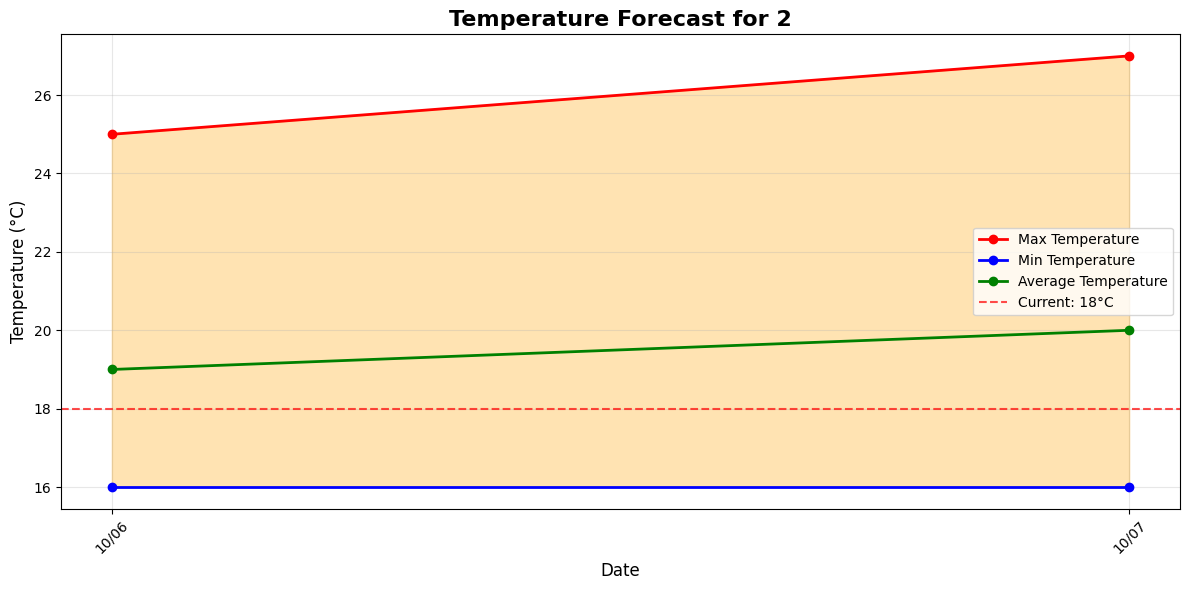


Main Menu:
1. Get weather forecast with visualizations
2. Ask a weather question in natural language
3. Compare weather for multiple locations
4. Exit
Please select an option (1-4): * 1
* 2
* 3
* 4
'Escape' is not a valid choice.
Please select an option (1-4): * 1
* 2
* 3
* 4

Thank you for using WeatherWise! Stay safe and dry!


In [12]:
# Main application execution
if __name__ == "__main__":
    try:
        main_menu()
    except Exception as e:
        print(f"❌ Application error: {e}")
        print("Please restart the application.")

## 🧪 Testing and Examples

In [13]:
# Example usage and testing
print("Testing WeatherWise Functions")
print("=" * 40)

# Test 1: Get weather data
print("\n1. Testing get_weather_data function:")
test_location = "London"
print(f"Getting weather for {test_location}...")
sample_weather = get_weather_data(test_location, 3)

if 'error' not in sample_weather:
    print("Weather data retrieved successfully!")
    print(f"Location: {sample_weather['location']}")
    print(f"Current temperature: {sample_weather['current']['temperature']}°C")
    print(f"Forecast days: {len(sample_weather['forecast'])}")
else:
    print(f"Error: {sample_weather['error']}")

# Test 2: Parse natural language question
print("\n2. Testing parse_weather_question function:")
test_questions = [
    "What's the weather like in Paris?",
    "Will it rain tomorrow in Tokyo?",
    "How hot will it be in New York this week?"
]

for question in test_questions:
    parsed = parse_weather_question(question)
    print(f"\nQ: '{question}'")
    print(f"   Location: {parsed['location']}")
    print(f"   Time: {parsed['time_period']}")
    print(f"   Attribute: {parsed['weather_attribute']}")

# Test 3: Generate response (if weather data is available)
if 'error' not in sample_weather:
    print("\n3. Testing generate_weather_response function:")
    test_parsed = {
        'location': 'London',
        'time_period': 'today',
        'weather_attribute': 'temperature',
        'question_type': 'current'
    }
    response = generate_weather_response(test_parsed, sample_weather)
    print(f"Response: {response}")

print("\nFunction testing completed!")
print("\nReady to run the full application!")
print("Execute the cell above to start the WeatherWise application.")

Testing WeatherWise Functions

1. Testing get_weather_data function:
Getting weather for London...
Weather data retrieved successfully!
Location: London
Current temperature: 11°C
Forecast days: 3

2. Testing parse_weather_question function:

Q: 'What's the weather like in Paris?'
   Location: Paris
   Time: today
   Attribute: general

Q: 'Will it rain tomorrow in Tokyo?'
   Location: Tokyo
   Time: tomorrow
   Attribute: precipitation

Q: 'How hot will it be in New York this week?'
   Location: New
   Time: week
   Attribute: temperature

3. Testing generate_weather_response function:
Response: Currently in London, it's 11°C (feels like 10°C).

Function testing completed!

Ready to run the full application!
Execute the cell above to start the WeatherWise application.


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.